In [1]:
from keras.datasets import mnist
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sys, os
%matplotlib inline
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [2]:
X_train = x_train.astype(np.float)
X_test = x_test.astype(np.float)
X_train /= 255
X_test /= 255
# print(X_train.max()) # 1.0
# print(X_train.min()) # 0.0

In [3]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

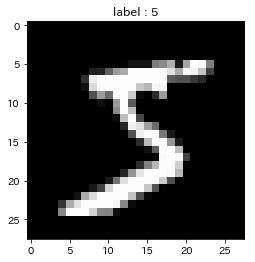

In [4]:
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [5]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64
y_train = y_train_one_hot
y_test = y_test_one_hot

(60000,)
(60000, 10)
float64


In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)
print(y_train.shape) # (48000, 784)
print(y_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)
(48000, 10)
(12000, 10)


In [7]:
def sigmoid(X):
    return 1/ (1 + np.exp(-X))

In [8]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [9]:
def softmax(A):
        """
        softmap関数
        """
        if A.ndim == 2:
            A = A.T
            A = A - np.max(A, axis=0)
            y = np.exp(A) / np.sum(np.exp(A), axis=0)
            return y.T

        A = A - np.max(A)
        return np.exp(A) / np.sum(np.exp(A))

# 【問題1】全結合層のクラス化

In [10]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.x = None
        self.dW = None
        self.dB = None
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.x = X.copy() #入力を引数で渡す。
#         print("X",X.shape)
#         print("self.W",self.W.shape)
        A = np.dot(X, self.W) + self.B
#         print("A",A.shape)
        return A
    
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dA = np.array(dA)
        dZ = np.dot(dA, self.W.T)#重みの形状の転置を行なって、それをdoutでdotする。
        self.dW = np.dot(self.x.T, dA)# 入力の形状の転置を行なって、それをdoutでdotする。
        self.dB = dA
        # 更新
        self = self.optimizer.update(self)
        return dZ


# 【問題2】初期化方法のクラス化

In [11]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1,n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(n_nodes2)
        return B


# 【問題3】最適化手法のクラス化

In [12]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W = layer.W - self.lr * layer.dW/layer.dB.shape[0]
        layer.B = layer.B - self.lr * layer.dB.mean(axis=0)
        return layer

# 【問題4】活性化関数のクラス化

In [13]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        dx = np.array(dx)
        return dx

In [14]:
class Softmax:
    def __init__(self):#インスタンス変数の初期化
        self.loss = None # 損失
        self.y = None # softmaxの出力
        self.t = None # 教師データ
        
    def forward(self,x):
        self.y = softmax(x) # softmax関数の出力
        return self.y #交差エントロピー誤差のインスタンス変数を返す。
    
    def backward(self,Z3,Y):
        self.y = Z3
        self.t = Y
        self.loss = cross_entropy_error(self.y, self.t) 
        batch_size = self.t.shape[0] #教師データの数を取得する
        dx = (self.y - self.t) / batch_size #教師データの数で割り算する。
        dx = np.array(dx)
        return dx, self.loss

# 【問題5】ReLUクラスの作成

In [15]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = x
        out = np.maximum(0,x)

        return out

    def backward(self):
        dx = np.where(self.mask > 0,1,0)

        return dx

# 【問題6】重みの初期値


In [16]:
class XavierInitializer:
    """
    Xavierによるシンプルな初期化
    Parameters
    ----------
   
    """
    def __init__(self,sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = 1/np.sqrt(n_nodes1) * np.random.randn(n_nodes1,n_nodes2)
        return W

    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = 1/np.sqrt(n_nodes2) * np.random.randn(n_nodes2)
        return B

    

In [17]:
class HeInitializer:
    """
    Heによるシンプルな初期化
    Parameters
    ----------
    
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = np.sqrt(2/n_nodes1) * np.random.randn(n_nodes1,n_nodes2)
        return W

    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.sqrt(2/n_nodes2) * np.random.randn(n_nodes2)
        return B



# 【問題7】最適化手法

In [18]:
class AdaGrad:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        self.h = None
        self.h2 = None
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        self.h = self.h - layer.dW/layer.dB.shape[0] * layer.dW / layer.dB.shape[0]
        layer.W = layer.W - self.lr * 1/np.sqrt(self.h) * layer.dW / layer.dB.shape[0]
        self.h2 = self.h2 - layer.dB/layer.dB.mean(axis=0) * layer.dB / layer.dB.mean(axis=0) 
        layer.B = layer.B - self.lr * 1/np.sqrt(self.h2) * layer.dB / layer.dB.mean(axis=0)
        return layer

In [19]:
class ScratchDeepNeuralNetrowkClassifier:
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(self):
        self.lr = 0.01
        self.sigma = 0.01 # ガウス分布の標準偏差
        batch_size = 10 # バッチサイズ
        self.n_features = 784 # 特徴量の数
        self.n_nodes1 = 400 # 1層目のノード数
        self.n_nodes2 = 200 # 2層目のノード数
        self.n_output = 10 # 出力のクラス数（3層目のノード数）
    
    
    def fit(self,optimizer = "SGD"):# オプティマイザーの基本はSGD。選択でAdaGradにできるようにする
        optimizer = SGD(self.lr)
        if optimizer == "AdaGrad":
            optimizer = AdaGrad(self.lr)
    
    
        self.FC1 = FC(self.n_features, self.n_nodes1, XavierInitializer(self.sigma), optimizer)
        self.activation1 = Sigmoid()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, XavierInitializer(self.sigma), optimizer)
        self.activation2 = Sigmoid()
        self.FC3 = FC(self.n_nodes2, self.n_output, XavierInitializer(self.sigma), optimizer)
        self.activation3 = Softmax()
    
        
    def predict(self,X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3
       
    def backward(self,Z3,Y):
        dA3,self.loss = self.activation3.backward(Z3, Y)# 交差エントロピー誤差とソフトマックスを合わせている
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dZ0 = self.FC1.backward(dA1) # dZ0は使用しない



In [20]:

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item * self.batch_size
        p1 = item * self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter * self.batch_size
        p1 = self._counter * self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

0 番目のエポック毎のLoss 2.4145129930093367
0 番目のエポック毎のVal_Loss 2.38915339089114
1 番目のエポック毎のLoss 2.362697504385421
1 番目のエポック毎のVal_Loss 2.350139443877281
2 番目のエポック毎のLoss 2.335121375729459
2 番目のエポック毎のVal_Loss 2.3289244411653987
3 番目のエポック毎のLoss 2.3203160254230033
3 番目のエポック毎のVal_Loss 2.3173236007901905
4 番目のエポック毎のLoss 2.3123622203284095
4 番目のエポック毎のVal_Loss 2.3109337555164036
5 番目のエポック毎のLoss 2.3080593327230177
5 番目のエポック毎のVal_Loss 2.3073483293293733
6 番目のエポック毎のLoss 2.30567755136238
6 番目のエポック毎のVal_Loss 2.305261920752293
7 番目のエポック毎のLoss 2.304294521902715
7 番目のエポック毎のVal_Loss 2.303974280623761
8 番目のエポック毎のLoss 2.303425485593818
8 番目のエポック毎のVal_Loss 2.303112871536985
9 番目のエポック毎のLoss 2.3028187332340884
9 番目のエポック毎のVal_Loss 2.302480259793379
10 番目のエポック毎のLoss 2.3023448052698683
10 番目のエポック毎のVal_Loss 2.3019717399116755
11 番目のエポック毎のLoss 2.3019376243918583
11 番目のエポック毎のVal_Loss 2.3015315056926515
12 番目のエポック毎のLoss 2.3015636866433695
12 番目のエポック毎のVal_Loss 2.30112954145298
13 番目のエポック毎のLoss 2.3012061140270963
13 番目のエポック毎

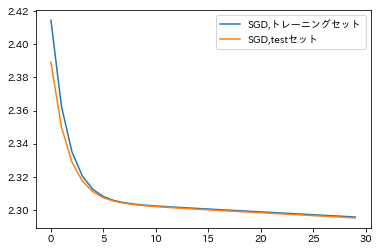

In [32]:
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=100)
get_mini_batch_val = GetMiniBatch(X_val, y_val, batch_size=100)
sdn = ScratchDeepNeuralNetrowkClassifier()
# print(len(get_mini_batch)) # 4800
# print(get_mini_batch[5]) # 5番目のミニバッチが取得できる
sdn.fit()
train_loss_list1 = []
train_loss_list2 = []
epocs = 30
for i in range(epocs):
    temp_loss=0
    j =0
    for mini_X_train, mini_y_train in get_mini_batch:
        j+=1
        mini_X_train = np.array(mini_X_train)
        mini_y_train = np.array(mini_y_train)
        if mini_X_train.ndim == 1:
            mini_X_train = mini_X_train[:, np.newaxis]
            
        if mini_y_train.ndim == 1:
            mini_y_train = mini_y_train[:, np.newaxis]
        Z = sdn.predict(mini_X_train)
        sdn.backward(Z,mini_y_train)
        temp_loss += sdn.loss
    average_loss = temp_loss/j
    print(i,"番目のエポック毎のLoss",average_loss)
    train_loss_list1.append(average_loss)

    
    temp_loss=0
    j =0
    for mini_X_val, mini_y_val in get_mini_batch_val:
        j+=1
        mini_X_val = np.array(mini_X_val)
        mini_y_val = np.array(mini_y_val)
        if mini_X_val.ndim == 1:
            mini_X_val = mini_X_val[:, np.newaxis]
            
        if mini_y_val.ndim == 1:
            mini_y_val = mini_y_val[:, np.newaxis]
        Z = sdn.predict(mini_X_val)
        sdn.backward(Z,mini_y_val)
        temp_loss += sdn.loss
    average_loss = temp_loss/j
    print(i,"番目のエポック毎のVal_Loss",average_loss)
    train_loss_list2.append(average_loss)

plt.plot(train_loss_list1,label="SGD,トレーニングセット")
plt.plot(train_loss_list2,label="SGD,testセット")
plt.legend()
plt.show()
    

    

0 番目のエポック毎のLoss 2.434443141237432
0 番目のエポック毎のVal_Loss 2.3967908899517263
1 番目のエポック毎のLoss 2.3771774688603
1 番目のエポック毎のVal_Loss 2.3549337094204503
2 番目のエポック毎のLoss 2.3444067515044864
2 番目のエポック毎のVal_Loss 2.330652824995601
3 番目のエポック毎のLoss 2.3251024869186634
3 番目のエポック毎のVal_Loss 2.316451453623895
4 番目のエポック毎のLoss 2.313706969919211
4 番目のエポック毎のVal_Loss 2.3082042597369403
5 番目のエポック毎のLoss 2.307018818279423
5 番目のエポック毎のVal_Loss 2.303460286999788
6 番目のエポック毎のLoss 2.3031037377521657
6 番目のエポック毎のVal_Loss 2.30073426126708
7 番目のエポック毎のLoss 2.3007870122137146
7 番目のエポック毎のVal_Loss 2.2991367308706474
8 番目のエポック毎のLoss 2.2993683630284996
8 番目のエポック毎のVal_Loss 2.2981501548267493
9 番目のエポック毎のLoss 2.2984423104737783
9 番目のエポック毎のVal_Loss 2.297483728148698
10 番目のエポック毎のLoss 2.297781111585424
10 番目のエポック毎のVal_Loss 2.2969796356876344
11 番目のエポック毎のLoss 2.297260228808894
11 番目のエポック毎のVal_Loss 2.2965549603250395
12 番目のエポック毎のLoss 2.29681298089649
12 番目のエポック毎のVal_Loss 2.296167439815707
13 番目のエポック毎のLoss 2.296404198382037
13 番目のエポック毎のVa

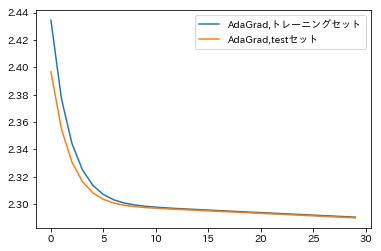

In [33]:
sdn.fit("AdaGrad")
train_loss_list1 = []
train_loss_list2 = []
epocs = 30
for i in range(epocs):
    temp_loss=0
    j =0
    for mini_X_train, mini_y_train in get_mini_batch:
        j+=1
        mini_X_train = np.array(mini_X_train)
        mini_y_train = np.array(mini_y_train)
        if mini_X_train.ndim == 1:
            mini_X_train = mini_X_train[:, np.newaxis]
            
        if mini_y_train.ndim == 1:
            mini_y_train = mini_y_train[:, np.newaxis]
        Z = sdn.predict(mini_X_train)
        sdn.backward(Z,mini_y_train)
        temp_loss += sdn.loss
    average_loss = temp_loss/j
    print(i,"番目のエポック毎のLoss",average_loss)
    train_loss_list1.append(average_loss)
    
    temp_loss=0
    j =0
    for mini_X_val, mini_y_val in get_mini_batch_val:
        j+=1
        mini_X_val = np.array(mini_X_val)
        mini_y_val = np.array(mini_y_val)
        if mini_X_val.ndim == 1:
            mini_X_val = mini_X_val[:, np.newaxis]
            
        if mini_y_val.ndim == 1:
            mini_y_val = mini_y_val[:, np.newaxis]
        Z = sdn.predict(mini_X_val)
        sdn.backward(Z,mini_y_val)
        temp_loss += sdn.loss
    average_loss = temp_loss/j
    print(i,"番目のエポック毎のVal_Loss",average_loss)
    train_loss_list2.append(average_loss)

plt.plot(train_loss_list1,label="AdaGrad,トレーニングセット")
plt.plot(train_loss_list2,label="AdaGrad,testセット")
plt.legend()
plt.show()